In [2]:
from io import BytesIO
from typing import Any, List, cast
import os
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from peft import LoraConfig
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from pdf2image import convert_from_path

# 加载图像的函数
def load_image_from_path(image_path: str) -> Image.Image:
    """
    从本地文件路径加载 PIL 图像。
    """
    return Image.open(image_path)

# 调整图像大小的函数
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    将图像缩放到指定高度，保持宽高比。
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)
    scaled_image = image.resize((new_width, new_height), Image.LANCZOS)  # 使用 LANCZOS 算法保持清晰度
    return scaled_image

# 自定义模型类，支持检索和生成两种模式
class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 模型的实现，支持检索和生成两种模式。
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        根据当前模式调用不同的 forward 方法。
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        使用 Qwen2VLForConditionalGeneration.generate 生成文本。
        """
        if not self.is_generation_enabled:
            raise ValueError("请先调用 enable_generation() 切换到生成模式。")
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self._is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        切换到检索模式。
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        切换到生成模式。
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False



In [3]:
# 设置模型和设备
model_name = "/huggingface/models/vidore/colqwen2-v1.0"
device = get_torch_device("auto")
print(f"使用设备: {device}")

# 加载 LoRA 配置
lora_config = LoraConfig.from_pretrained(model_name)

# 加载处理器
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))

# 加载模型
model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)

使用设备: cuda:0


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# PDF 文件路径
pdf_path = "/Data/PDF/2023tj.pdf"  # 替换为你的实际 PDF 路径

# 将 PDF 转换为图像
images: List[Image.Image] = convert_from_path(pdf_path)

# 调整图像尺寸
images = [scale_image(image, new_height=1024) for image in images]

# 定义多个查询内容
queries = [
    "天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?",
    "天津市2023年居民人均可支配收入是多少? 比上年增长了多少?",
    "你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?",
    "天津市2023年全年一般公共预算收入是多少? 战略性新兴产业增加值占工业的比重是多少?",
    "天津市2022年地区生产总值增长速度是多少?",
    "天津市2021年天津市三次产业结构的占比分别是多少?",
    "天津市2023年居民消费价格月度涨跌幅度中，10月的月度同比是多少?月度环比是多少?",
    "天津市2023年天津市居民消费价格涨幅中，交通通信比上年上涨了百分之多少?",
    "天津市2020年粮食产量是多少?",
    "天津市2023年主要工业产品产量及增长速度中，新能源汽车的产量是多少?",
    "天津市2023年旅客运输业务量及增长速度中，客运量中的公路的绝对数是多少?",
    "天津市2023年民用汽车拥有量是多少?",
    "天津市2022年外贸进口与出口中，进口与出口的费用分别是多少钱?",
    "天津市2023年集装箱吞吐量是多少?",
    "天津市2022年技术合同成交额情况是多少?",
    "天津市2021年职业医师和注册护士情况中，执业医师的人数是多少?",
    ]

# 处理图像
batch_images = processor_retrieval.process_images(images).to(model.device)

# 启动检索模式
model.enable_retrieval()

检索到的图像对应查询: 天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?


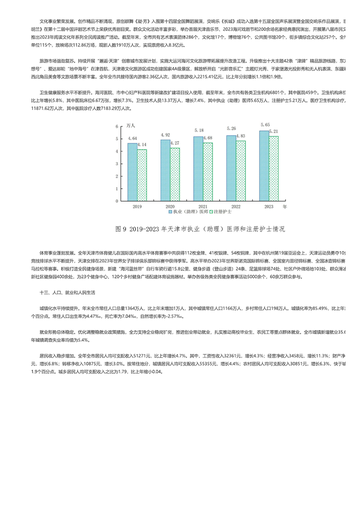

查询: 天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?
回答: 根据图9的内容，天津市在国际国内高水平体育赛事中获得的金牌、银牌、铜牌分别是：

- 金牌：112枚
- 银牌：41枚
- 铜牌：54枚

检索到的图像对应查询: 天津市2023年居民人均可支配收入是多少? 比上年增长了多少?


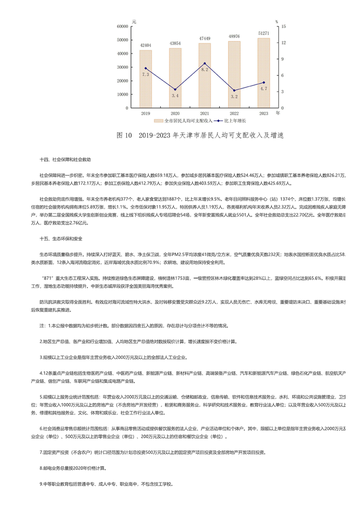

查询: 天津市2023年居民人均可支配收入是多少? 比上年增长了多少?
回答: 根据图10，2023年天津市居民人均可支配收入为51271元，比上年增长了4.7%。

检索到的图像对应查询: 你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?


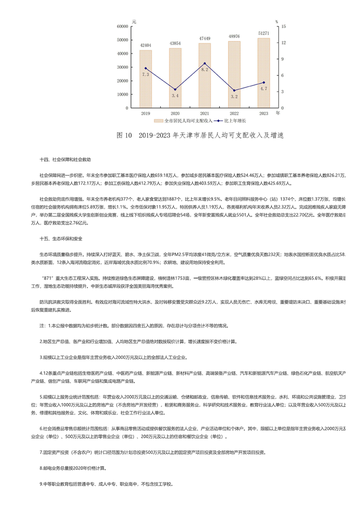

查询: 你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?
回答: 2019年-2023年天津市居民人均可支配收入的总结如下：

1. **总体趋势**：2019年到2023年，天津市居民人均可支配收入总体呈上升趋势，但增速有所放缓。

2. **年增长率**：2019年到2023年，天津市居民人均可支配收入的年增长率分别为7.3%、8.2%、4.7%、4.7%和5.1%，总体上呈现逐年下降的趋势。

3. **收入结构**：居民人均可支配收入

检索到的图像对应查询: 天津市2023年全年一般公共预算收入是多少? 战略性新兴产业增加值占工业的比重是多少?


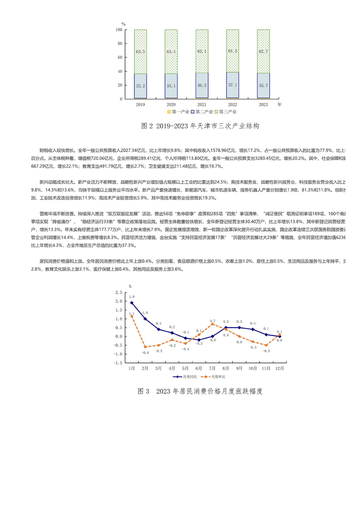

查询: 天津市2023年全年一般公共预算收入是多少? 战略性新兴产业增加值占工业的比重是多少?
回答: 根据图2，2023年天津市全年一般公共预算收入为2027.34亿元。

战略性新兴产业增加值占工业的比重为24.5%。

检索到的图像对应查询: 天津市2022年地区生产总值增长速度是多少?


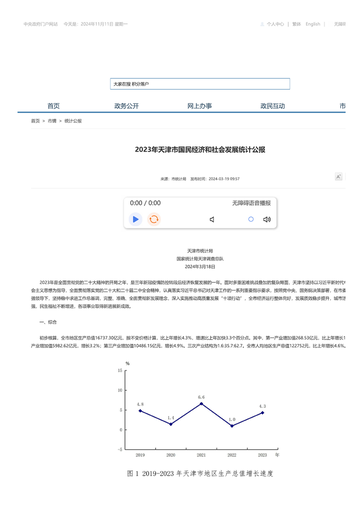

查询: 天津市2022年地区生产总值增长速度是多少?
回答: 天津市2022年地区生产总值增长速度是4.3%。

检索到的图像对应查询: 天津市2021年天津市三次产业结构的占比分别是多少?


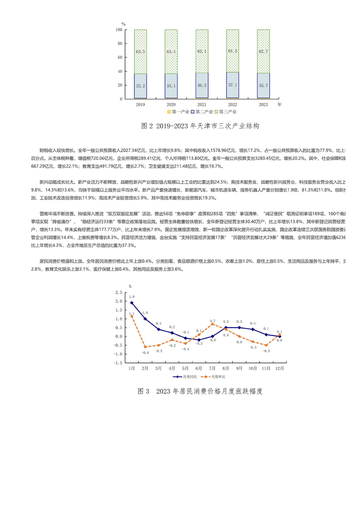

查询: 天津市2021年天津市三次产业结构的占比分别是多少?
回答: 根据图2，2021年天津市三次产业结构的占比分别是：

- 第一产业：36.2%
- 第二产业：61.2%
- 第三产业：35.7%

检索到的图像对应查询: 天津市2023年居民消费价格月度涨跌幅度中，10月的月度同比是多少?月度环比是多少?


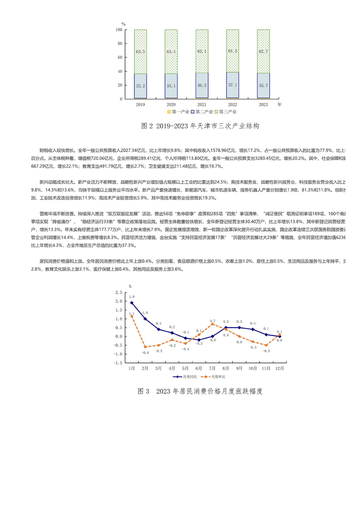

查询: 天津市2023年居民消费价格月度涨跌幅度中，10月的月度同比是多少?月度环比是多少?
回答: 根据图3，2023年10月的月度同比是-0.5，月度环比是0.1。

检索到的图像对应查询: 天津市2023年天津市居民消费价格涨幅中，交通通信比上年上涨了百分之多少?


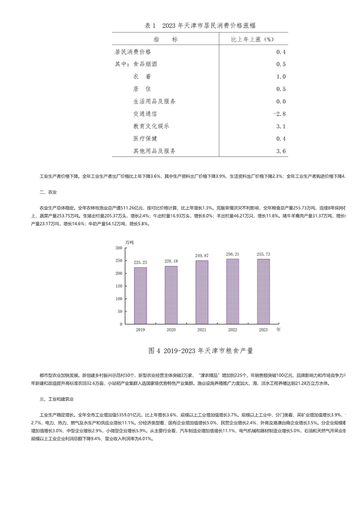

查询: 天津市2023年天津市居民消费价格涨幅中，交通通信比上年上涨了百分之多少?
回答: 天津市2023年居民消费价格涨幅中，交通通信比上年上涨了2.8%。

检索到的图像对应查询: 天津市2020年粮食产量是多少?


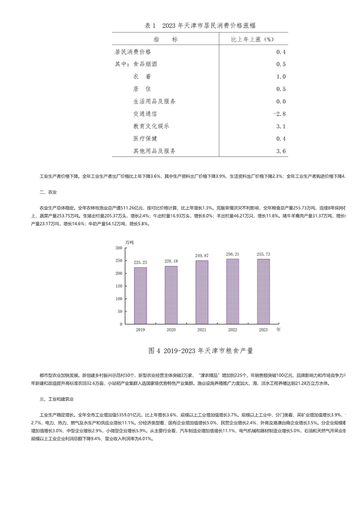

查询: 天津市2020年粮食产量是多少?
回答: 根据图表，2020年天津市粮食产量为228.18万吨。

检索到的图像对应查询: 天津市2023年主要工业产品产量及增长速度中，新能源汽车的产量是多少?


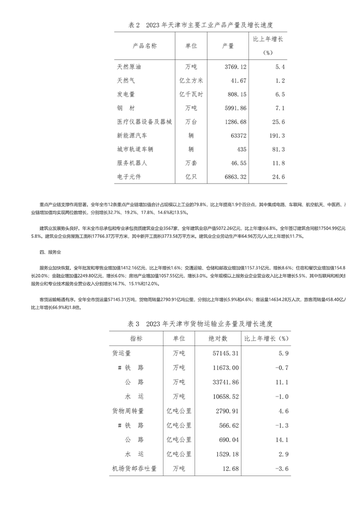

查询: 天津市2023年主要工业产品产量及增长速度中，新能源汽车的产量是多少?
回答: 天津市2023年主要工业产品产量及增长速度中，新能源汽车的产量是63372辆。

检索到的图像对应查询: 天津市2023年旅客运输业务量及增长速度中，客运量中的公路的绝对数是多少?


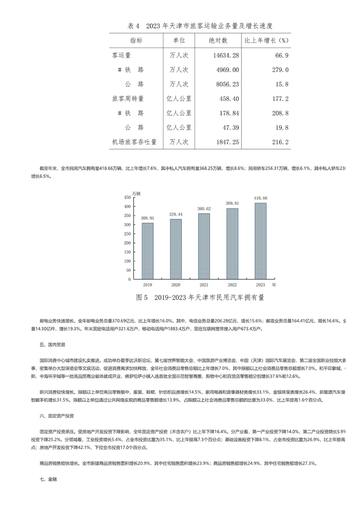

查询: 天津市2023年旅客运输业务量及增长速度中，客运量中的公路的绝对数是多少?
回答: 天津市2023年旅客运输业务量及增长速度中，客运量中的公路的绝对数是8056.23万人次。

检索到的图像对应查询: 天津市2023年民用汽车拥有量是多少?


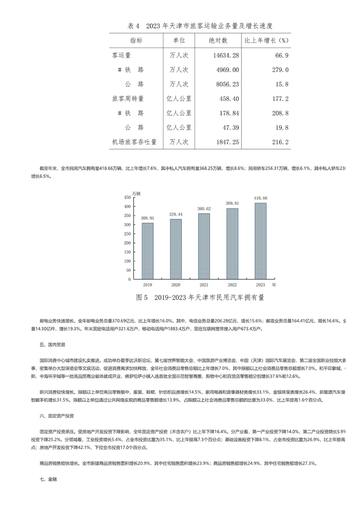

查询: 天津市2023年民用汽车拥有量是多少?
回答: 截至年末，天津市民用汽车拥有量为418.66万辆，比上年增长7.6%。

检索到的图像对应查询: 天津市2022年外贸进口与出口中，进口与出口的费用分别是多少钱?


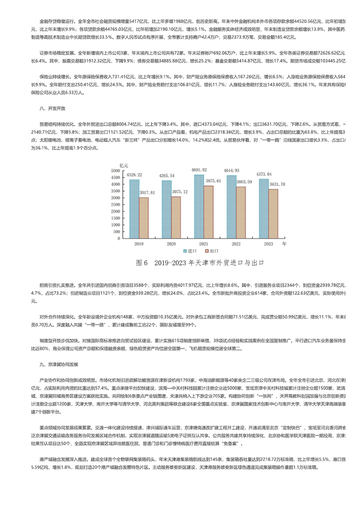

查询: 天津市2022年外贸进口与出口中，进口与出口的费用分别是多少钱?
回答: 根据图6，2022年天津市外贸进口与出口的费用如下：

- 进口费用：4691.82亿元
- 出口费用：4691.82亿元

因此，天津市2022年外贸进口与出口的费用都是4691.82亿元。

检索到的图像对应查询: 天津市2023年集装箱吞吐量是多少?


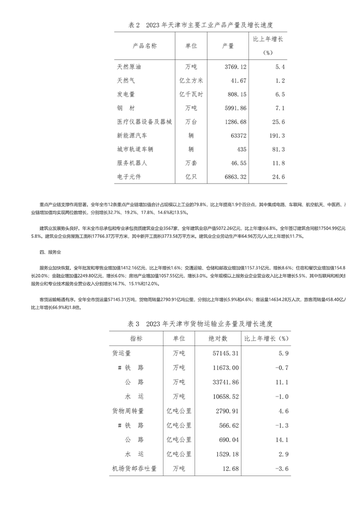

查询: 天津市2023年集装箱吞吐量是多少?
回答: 根据输入的表格，2023年天津市集装箱吞吐量为12.68万吨。

检索到的图像对应查询: 天津市2022年技术合同成交额情况是多少?


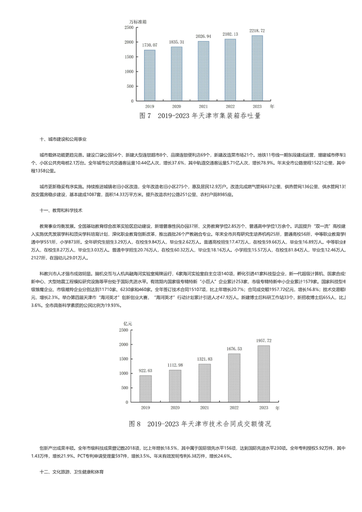

查询: 天津市2022年技术合同成交额情况是多少?
回答: 根据图8，2022年天津市技术合同成交额为1676.53亿元。

检索到的图像对应查询: 天津市2021年职业医师和注册护士情况中，执业医师的人数是多少?


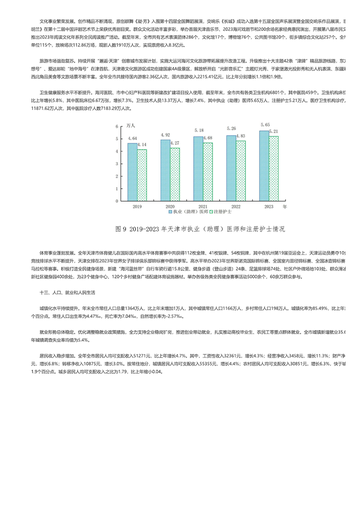

查询: 天津市2021年职业医师和注册护士情况中，执业医师的人数是多少?
回答: 天津市2021年职业医师和注册护士情况中，执业医师的人数是5.18万人。



In [11]:
# 为每个 query 进行检索和生成
for query in queries:
    # 处理单个 query
    batch_query = processor_retrieval.process_queries([query]).to(model.device)

    # 计算图像和查询的嵌入
    with torch.no_grad():
        image_embeddings = model.forward(**batch_images)
        query_embeddings = model.forward(**batch_query)

    # 计算相似度
    scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

    # 获取最相关的图像
    retrieved_image_index = scores.argmax().item()
    retrieved_image = images[retrieved_image_index]

    print(f"检索到的图像对应查询: {query}")
    display(scale_image(retrieved_image, new_height=512))  # 显示检索到的图像

    # 生成回答
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": retrieved_image},
                {"type": "text", "text": f"根据输入图像回答以下问题: {query}"},
            ],
        }
    ]
    text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
    inputs_generation = processor_generation(
        text=[text_prompt],
        images=[retrieved_image],
        padding=True,
        return_tensors="pt",
    ).to(device)

    # 切换到生成模式并生成回答
    model.enable_generation()
    output_ids = model.generate(**inputs_generation, max_new_tokens=128)

    # 处理生成的文本
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]
    output_text = processor_generation.batch_decode(
        generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

    # 输出结果
    print(f"查询: {query}")
    print(f"回答: {output_text[0]}\n")

    # 切换回检索模式以处理下一个 query
    model.enable_retrieval()

### 上面的是多 Query 的问答 ，已经实现
### 下面的是 将Query 放入到文本当中，输出也是文本保存

In [4]:
pdf_path = "/Data/PDF/2023tj.pdf"  # 替换为你的实际 PDF 路径

# 将 PDF 转换为图像
images: List[Image.Image] = convert_from_path(pdf_path)

# 调整图像尺寸
images = [scale_image(image, new_height=1024) for image in images]

# 从文本文件读取查询
query_file = "/Colpali/self_test/final_test/querys.txt"  # 查询存储在 queries.txt 文件中
with open(query_file, "r", encoding="utf-8") as f:
    queries = [line.strip() for line in f if line.strip()]

# 创建结果输出文件
results_file = "/Colpali/self_test/final_test/results.txt"
with open(results_file, "w", encoding="utf-8") as f:
    f.write("查询与回答结果\n")
    f.write("=" * 50 + "\n")

# 创建控制台输出文件
console_file = "console_output.txt"
with open(console_file, "w", encoding="utf-8") as f:
    f.write("控制台输出记录\n")
    f.write("=" * 50 + "\n")

# 将设备信息写入控制台输出文件
with open(console_file, "a", encoding="utf-8") as f:
    f.write(f"使用设备: {device}\n")

# 处理图像
batch_images = processor_retrieval.process_images(images).to(model.device)

# 启动检索模式
model.enable_retrieval()

# 为每个 query 进行检索和生成
for query in queries:
    # 处理单个 query
    batch_query = processor_retrieval.process_queries([query]).to(model.device)

    # 计算图像和查询的嵌入
    with torch.no_grad():
        image_embeddings = model.forward(**batch_images)
        query_embeddings = model.forward(**batch_query)

    # 计算相似度
    scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

    # 获取最相关的图像索引
    retrieved_image_index = scores.argmax().item()
    page_number = retrieved_image_index + 1  # 页码从 1 开始

    # 获取检索到的图像
    retrieved_image = images[retrieved_image_index]

    # 生成回答
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": retrieved_image},
                {"type": "text", "text": f"根据输入图像回答以下问题: {query}"},
            ],
        }
    ]
    text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
    inputs_generation = processor_generation(
        text=[text_prompt],
        images=[retrieved_image],
        padding=True,
        return_tensors="pt",
    ).to(device)

    # 切换到生成模式并生成回答
    model.enable_generation()
    output_ids = model.generate(**inputs_generation, max_new_tokens=128)

    # 处理生成的文本
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]
    output_text = processor_generation.batch_decode(
        generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

    # 控制台输出并保存到 console_output.txt
    console_output = f"查询: {query}\n检索到的图像页索引: {page_number}\n回答: {output_text[0]}\n"
    print(console_output)
    with open(console_file, "a", encoding="utf-8") as f:
        f.write(console_output + "\n")

    # 写入结果到 results.txt
    with open(results_file, "a", encoding="utf-8") as f:
        f.write(f"查询: {query}\n")
        f.write(f"检索到的图像页索引: {page_number}\n")
        f.write(f"回答: {output_text[0]}\n")
        f.write("-" * 50 + "\n")

    # 切换回检索模式以处理下一个 query
    model.enable_retrieval()


查询: 天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?
检索到的图像页索引: 8
回答: 根据图9的内容，天津市在国际国内高水平体育赛事中获得的金牌、银牌、铜牌分别是：

- 金牌：112枚
- 银牌：41枚
- 铜牌：54枚

查询: 天津市2023年居民人均可支配收入是多少? 比上年增长了多少?
检索到的图像页索引: 9
回答: 根据图10，2023年天津市居民人均可支配收入为51271元，比上年增长了4.7%。

查询: 你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?
检索到的图像页索引: 9
回答: 2019年-2023年天津市居民人均可支配收入的总结如下：

1. **总体趋势**：2019年到2023年，天津市居民人均可支配收入总体呈上升趋势，但增速有所放缓。

2. **年增长率**：2019年到2023年，天津市居民人均可支配收入的年增长率分别为7.3%、8.2%、4.7%、4.7%和5.1%，总体上呈现逐年下降的趋势。

3. **收入结构**：居民人均可支配收入

查询: 天津市2023年全年一般公共预算收入是多少? 战略性新兴产业增加值占工业的比重是多少?
检索到的图像页索引: 2
回答: 根据图2，2023年天津市全年一般公共预算收入为2027.34亿元。

战略性新兴产业增加值占工业的比重为24.5%。

查询: 天津市2022年地区生产总值增长速度是多少?
检索到的图像页索引: 1
回答: 天津市2022年地区生产总值增长速度是4.3%。

查询: 天津市2021年天津市三次产业结构的占比分别是多少?
检索到的图像页索引: 2
回答: 根据图2，2021年天津市三次产业结构的占比分别是：

- 第一产业：36.2%
- 第二产业：61.2%
- 第三产业：35.7%

查询: 天津市2023年居民消费价格月度涨跌幅度中，10月的月度同比是多少?月度环比是多少?
检索到的图像页索引: 2
回答: 根据图3，2023年10月的月度同比是-0.5，月度环比是0.1。

查询: 天津市2023年天津市居民消费价格涨幅中，交通通信比上年上涨了百分之多少?
检索到的图像页索引: 3
回答: 天津市2023年居民消费价格涨幅中，交通通信比上年上涨了2.8%。

查询: 天津市2020年粮食产量是多

### 接下来是多 PDF 多 Query 继续的问答

In [ ]:
# PDF 文件路径列表
pdf_paths = [
    "/Data/PDF/2023tj.pdf",
    "/Data/PDF/7号.pdf",
]
# 可以添加更多 PDF 文件路径，例如 "/path/to/2021tj.pdf"
# 从文本文件读取查询和对应的 PDF 索引
query_file = "/Colpali/self_test/final_test/querys.txt"
with open(query_file, "r", encoding="utf-8") as f:
    queries_with_pdf = [line.strip().rsplit(maxsplit=1) for line in f if line.strip()]
    # 将 PDF 索引转换为整数
    queries_with_pdf = [(query, int(pdf_index)) for query, pdf_index in queries_with_pdf]
# 创建结果输出文件
results_file = "/Colpali/self_test/final_test/results.txt"
with open(results_file, "w", encoding="utf-8") as f:
    f.write("查询与回答结果\n")
    f.write("=" * 50 + "\n")

# 创建控制台输出文件
console_file = "console_output.txt"
with open(console_file, "w", encoding="utf-8") as f:
    f.write("控制台输出记录\n")
    f.write("=" * 50 + "\n")
    f.write(f"使用设备: {device}\n")

# 启动检索模式
model.enable_retrieval()

# 为每个查询进行检索和生成
for query, pdf_index in queries_with_pdf:
    pdf_path = pdf_paths[pdf_index]

    # 将 PDF 转换为图像
    images: List[Image.Image] = convert_from_path(pdf_path)

    # 调整图像尺寸
    images = [scale_image(image, new_height=1024) for image in images]

    # 处理图像
    batch_images = processor_retrieval.process_images(images).to(model.device)

    # 处理单个查询
    batch_query = processor_retrieval.process_queries([query]).to(model.device)

    # 计算图像和查询的嵌入
    with torch.no_grad():
        image_embeddings = model.forward(**batch_images)
        query_embeddings = model.forward(**batch_query)

    # 计算相似度
    scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

    # 获取最相关的图像索引
    retrieved_image_index = scores.argmax().item()
    page_number = retrieved_image_index + 1  # 页码从 1 开始

    # 获取检索到的图像
    retrieved_image = images[retrieved_image_index]

    # 生成回答
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": retrieved_image},
                {"type": "text", "text": f"根据输入图像回答以下问题: {query}"},
            ],
        }
    ]
    text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
    inputs_generation = processor_generation(
        text=[text_prompt],
        images=[retrieved_image],
        padding=True,
        return_tensors="pt",
    ).to(device)

    # 切换到生成模式并生成回答
    model.enable_generation()
    output_ids = model.generate(**inputs_generation, max_new_tokens=128)

    # 处理生成的文本
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]
    output_text = processor_generation.batch_decode(
        generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

    # 控制台输出并保存
    console_output = (
        f"查询: {query}\n"
        f"PDF 文件: {pdf_path}\n"
        f"检索到的图像页索引: {page_number}\n"
        f"回答: {output_text[0]}\n"
    )
    print(console_output)
    with open(console_file, "a", encoding="utf-8") as f:
        f.write(console_output + "\n")

    # 写入结果文件
    with open(results_file, "a", encoding="utf-8") as f:
        f.write(f"查询: {query}\n")
        f.write(f"PDF 文件: {pdf_path}\n")
        f.write(f"检索到的图像页索引: {page_number}\n")
        f.write(f"回答: {output_text[0]}\n")
        f.write("-" * 50 + "\n")

    # 切换回检索模式
    model.enable_retrieval()

In [ ]:
'''

查询: 天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 8
回答: 根据图9的内容，天津市在国际国内高水平体育赛事中获得的金牌、银牌、铜牌分别是：

- 金牌：112枚
- 银牌：41枚
- 铜牌：54枚

查询: 天津市2023年居民人均可支配收入是多少? 比上年增长了多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 9
回答: 根据图10，2023年天津市居民人均可支配收入为51271元，比上年增长了4.7%。

查询: 你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 9
回答: 2019年-2023年天津市居民人均可支配收入的总结如下：

1. **总体趋势**：2019年到2023年，天津市居民人均可支配收入总体呈上升趋势，但增速有所放缓。

2. **年增长率**：2019年到2023年，天津市居民人均可支配收入的年增长率分别为7.3%、8.2%、4.7%、4.7%和5.1%，总体上呈现逐年下降的趋势。

3. **收入结构**：居民人均可支配收入

查询: 天津市2023年全年一般公共预算收入是多少? 战略性新兴产业增加值占工业的比重是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 2
回答: 根据图2，2023年天津市全年一般公共预算收入为2027.34亿元。

战略性新兴产业增加值占工业的比重为24.5%。

查询: 天津市2022年地区生产总值增长速度是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 1
回答: 天津市2022年地区生产总值增长速度是4.3%。

查询: 天津市2021年天津市三次产业结构的占比分别是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 2
回答: 根据图2，2021年天津市三次产业结构的占比分别是：

- 第一产业：36.2%
- 第二产业：61.2%
- 第三产业：35.7%

查询: 天津市2023年居民消费价格月度涨跌幅度中，10月的月度同比是多少? 月度环比是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 2
回答: 根据图3，2023年10月的月度同比是-0.5，月度环比是0.1。

查询: 天津市2023年天津市居民消费价格涨幅中，交通通信比上年上涨了百分之多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 3
回答: 天津市2023年居民消费价格涨幅中，交通通信比上年上涨了2.8%。

查询: 天津市2020年粮食产量是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 3
回答: 根据图表，2020年天津市粮食产量为228.18万吨。

查询: 天津市2023年主要工业产品产量及增长速度中，新能源汽车的产量是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 4
回答: 天津市2023年主要工业产品产量及增长速度中，新能源汽车的产量是63372辆。

查询: 天津市2023年旅客运输业务量及增长速度中，客运量中的公路的绝对数是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 5
回答: 天津市2023年旅客运输业务量及增长速度中，客运量中的公路的绝对数是8056.23万人次。

查询: 天津市2023年民用汽车拥有量是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 5
回答: 截至年末，天津市民用汽车拥有量为418.66万辆，比上年增长7.6%。

查询: 天津市2022年外贸进口与出口中，进口与出口的费用分别是多少钱?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 6
回答: 根据图6，2022年天津市外贸进口与出口的费用如下：

- 进口费用：4691.82亿元
- 出口费用：4691.82亿元

因此，天津市2022年外贸进口与出口的费用都是4691.82亿元。

查询: 天津市2023年集装箱吞吐量是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 4
回答: 根据输入的表格，2023年天津市集装箱吞吐量为12.68万吨。

查询: 天津市2022年技术合同成交额情况是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 7
回答: 根据图8，2022年天津市技术合同成交额为1676.53亿元。

查询: 天津市2021年职业医师和注册护士情况中，执业医师的人数是多少?
PDF 文件: /Data/PDF/2023tj.pdf
检索到的图像页索引: 8
回答: 天津市2021年职业医师和注册护士情况中，执业医师的人数是5.18万人。

查询: 天津市按地区分组的法人单位数和生产活动单位数中，东丽区的法人单位数量与比重是多少?
PDF 文件: /Data/PDF/7号.pdf
检索到的图像页索引: 2
回答: 根据表格，东丽区的法人单位数量为2.84万个，比重为6.7%。

查询: 天津市按地区分组的法人单位从业人员中，红桥区的法人单位从业人员数量是多少?
PDF 文件: /Data/PDF/7号.pdf
检索到的图像页索引: 2
回答: 根据表格7-1，红桥区的法人单位从业人员数量为0.95万个。

'''

